# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

Основные шаги:

- Загрузите данные, путь к файлу: `/datasets/autos.csv`
- Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их
- Подготовьте выборки для обучения моделей
- Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры
- Проанализируйте время обучения, время предсказания и качество моделей
- Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке

Примечания:
- Для оценки качества моделей применяйте метрику RMSE
- Значение метрики RMSE должно быть меньше 2500
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором `del`

        del features_train

Описание данных
- Данные находятся в файле [/datasets/autos.csv](https://code.s3.yandex.net/datasets/autos.csv "code.s3.yandex.net/datasets/autos.csv") 

Признаки
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак
- `Price` — цена (евро)

## Подготовка данных

In [23]:
# отключим предупреждающие уведомления
import warnings
warnings.filterwarnings('ignore')

# Добавим основные библиотеки
import pandas as pd
import numpy as np
import os.path
import math

# Добавим библиотеки для отрисовки графиков
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

# добавим необходимые библиотеки для построения моделей
from sklearn.model_selection import train_test_split
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Сделаем небольшие настройки pandas для комфортного отображения проекта
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [24]:
# Импортируем датасеты методом try/except и установим индексом столбец date
try:
    path_df = os.path.join('datasets/autos.csv')
    df = pd.read_csv(path_df)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [25]:
# Функция для вывода первичной информации по датасету
def first_view(data):
    title_lenght = 79
    title_one = 'Обзор данных первых и последних пяти строк'
    print('~' * int((title_lenght - len(title_one)) / 2), title_one, '~' * (title_lenght - len(title_one) - int((title_lenght - len(title_one)) / 2)))
    display(data.head(5))
    display(data.tail(5))
    print()
    title_two = 'Основная описательная статистика'
    print('~' * int((title_lenght - len(title_two)) / 2), title_two, '~' * (title_lenght - len(title_two) - int((title_lenght - len(title_two)) / 2)))
    display(data.describe())
    print()
    title_three = 'Тип данных' 
    print('~' * int((title_lenght - len(title_three)) / 2), title_three, '~' * (title_lenght - len(title_three) - int((title_lenght - len(title_three)) / 2)))
    data.info()
    print()
    title_four = 'Подсчёт пропусков'
    print('~' * int((title_lenght - len(title_four)) / 2), title_four, '~' * (title_lenght - len(title_four) - int((title_lenght - len(title_four)) / 2)))
    all_nulls = 0
    for col in data.columns:
       if data[col].isna().sum() > 0:
            all_nulls += 1
            print(f"{data[col].isna().sum()} пропусков в колонке {col}. Это {round(data[col].isna().mean() * 100, 2)}%")
    if all_nulls == 0:
        print('В датафрейме пропуски отсутствуют')
    print()
    title_five = 'Явные дубликаты'
    print('~' * int((title_lenght - len(title_five)) / 2), title_five, '~' * (title_lenght - len(title_five) - int((title_lenght - len(title_five)) / 2)))
    if data.duplicated().sum() > 0:
        print('Количество явных дубликатов - ', data.duplicated().sum())
    else:
        print('Явные дубликаты в датасете отсутствуют')
    print()
    title_six = 'Просмотр гистограмм датафрейма'
    print('~' * int((title_lenght - len(title_six)) / 2), title_six, '~' * (title_lenght - len(title_six) - int((title_lenght - len(title_six)) / 2)))
    data.hist(bins=50, figsize = (8, 8));

~~~~~~~~~~~~~~~~~~ Обзор данных первых и последних пяти строк ~~~~~~~~~~~~~~~~~~~


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21



~~~~~~~~~~~~~~~~~~~~~~~ Основная описательная статистика ~~~~~~~~~~~~~~~~~~~~~~~~


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.00,354369.00,354369.00,354369.00,354369.00,354369.00,354369.00
mean,4416.66,2004.23,110.09,128211.17,5.71,0.00,50508.69
std,4514.16,90.23,189.85,37905.34,3.73,0.00,25783.10
min,0.00,1000.00,0.00,5000.00,0.00,0.00,1067.00
25%,1050.00,1999.00,69.00,125000.00,3.00,0.00,30165.00
50%,2700.00,2003.00,105.00,150000.00,6.00,0.00,49413.00
75%,6400.00,2008.00,143.00,150000.00,9.00,0.00,71083.00
max,20000.00,9999.00,20000.00,150000.00,12.00,0.00,99998.00



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Тип данных ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-nul

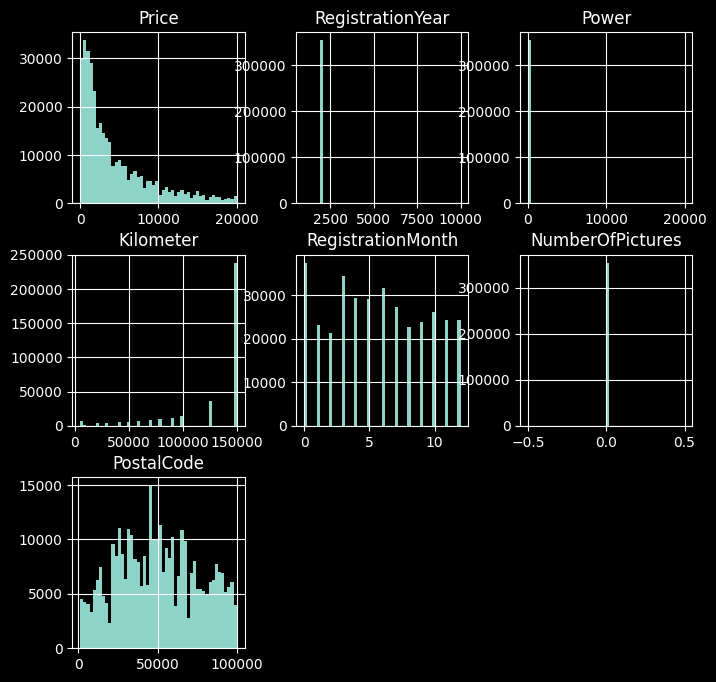

In [26]:
first_view(df)

Вывод из первичного осмотра данных:

- имеются пропуски
- имеются дубликаты
- имеются анамальные значения в параметрах года регистрации и мощности двигателя
- количество изображений полностью пустой столбец в котором все значения нулевые
- в целевом признаке присутствуют нулевые значения цены
- в колонке месяц регистрации есть нулевое значение и это не начало отсчета с нуля, потому как есть и 12

Проанализируем данные подробней, по ходу дела подготавливая данные

Для начала переименуем столбцы, сгруппируем их по смыслу для удобства и сразу избавимся от лишнего (пустой колонки с нулевым количеством картинок везде)

In [27]:
df.columns.tolist()

['DateCrawled',
 'Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'Repaired',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode',
 'LastSeen']

In [28]:
df = df.rename(columns={
    'Price':'price',
    'VehicleType':'vehicle_type',
    'RegistrationYear':'reg_year',
    'Gearbox':'gearbox',
    'Power':'power',
    'Model':'model',
    'Kilometer':'km',
    'RegistrationMonth':'reg_month',
    'FuelType':'fuel_type',
    'Brand':'brand',
    'Repaired':'repaired',
    'PostalCode':'postal_code',
    'DateCreated':'date_created',
    'DateCrawled':'date_crawled',
    'LastSeen':'date_last_seen'
})

df.columns.tolist() # проверяем

['date_crawled',
 'price',
 'vehicle_type',
 'reg_year',
 'gearbox',
 'power',
 'model',
 'km',
 'reg_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'NumberOfPictures',
 'postal_code',
 'date_last_seen']

In [29]:
df = df[['date_created',
         'date_crawled',
         'date_last_seen',
         'postal_code',
         'vehicle_type',
         'fuel_type',
         'brand',
         'model',
         'reg_year',
         'reg_month',
         'km',
         'gearbox',
         'power',
         'repaired',
         'price'
         ]]

Избавимся от дубликатов

In [30]:
df.drop_duplicates(inplace=True, ignore_index=True)

Избавимся от аномалий в столбце с когдом регистрации авто

In [31]:
shape_before = df.shape[0]
df = df.loc[(df['reg_year'] > 1900) & (df['reg_year'] < 2016)]
print(f'удалено строк: {shape_before - df.shape[0]}')

удалено строк: 24195


Избавимся от аномалий в столбце с мощностью двигателя

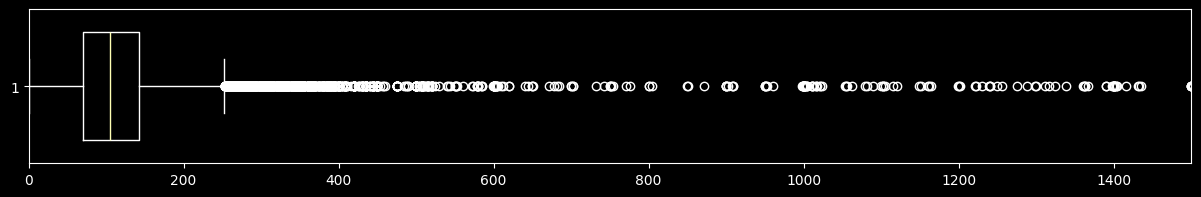

In [32]:
plt.figure(figsize=(15,2))
plt.boxplot(df['power'], vert=False, widths=0.7)
plt.xlim(0,1500)
plt.show();

Присутствуют очень большие выбросы. Конечно существуют автомобили с такими мощными двигателями, но скорее сего это аномалии в данных. Посмотрим глазами на эти выбросы

In [33]:
df.loc[df['power'] > 300].sort_values(by='power', ascending=False)

,date_created,date_crawled,date_last_seen,postal_code,vehicle_type,fuel_type,brand,model,reg_year,reg_month,km,gearbox,power,repaired,price
219583,2016-03-09 00:00:00,2016-03-09 15:43:53,2016-03-30 08:47:08,19406,coupe,petrol,mercedes_benz,clk,1999,1,150000,auto,20000,no,4300
299177,2016-03-09 00:00:00,2016-03-09 08:53:11,2016-04-07 11:44:34,21129,wagon,NaN,bmw,5er,1997,1,150000,manual,19312,no,1500
114106,2016-04-03 00:00:00,2016-04-03 07:36:21,2016-04-07 10:16:10,45964,sedan,gasoline,bmw,1er,2006,0,125000,manual,19211,NaN,9999
132485,2016-03-25 00:00:00,2016-03-25 14:55:49,2016-03-30 05:16:18,59556,wagon,NaN,bmw,5er,2001,5,150000,manual,19208,yes,2100
63986,2016-03-28 00:00:00,2016-03-28 11:49:56,2016-04-06 14:17:21,86641,sedan,petrol,opel,omega,2001,6,150000,auto,17932,NaN,3250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128896,2016-03-19 00:00:00,2016-03-19 23:36:35,2016-04-02 05:15:39,25764,other,petrol,daihatsu,cuore,1998,4,125000,manual,301,no,1000
130007,2016-03-06 00:00:00,2016-03-06 10:49:30,2016-03-14 19:15:18,46483,coupe,petrol,nissan,NaN,2007,8,125000,manual,301,no,13900
224430,2016-04-04 00:00:00,2016-04-04 14:48:57,2016-04-06 16:17:21,84036,coupe,petrol,audi,NaN,1998,0,125000,manual,301,no,5990
11197,2016-03-26 00:00:00,2016-03-26 22:51:57,2016-04-06 18:48:25,10829,coupe,petrol,nissan,other,2005,5,150000,manual,301,NaN,11000


Чаще это серийные автомобили (audi, opel, bmw) и велика вероятность того что мощность экстримально завышена, но попадаются и действительно мощные авто вроде porshe. Сложно провести грань между аномалиями и просто выбросами, придётся либо оставить часть аномалий, но сохранить полезные данные, либо отрезать полезные данные, но избавится от аномалий. Оставим часть аномалий и избавимся только от очевидных аномалий, дабы не потерять полезные данные в сегменте мощных авто. Так же удалим автомобили с мощностью в ноль л.с.

In [34]:
shape_before = df.shape[0]
df = df.loc[(df['power'] < 500) & (df['power'] != 0)]
print(f'удалено строк: {shape_before - df.shape[0]}')

удалено строк: 34081


Удалим аномлалии в целевом признаке

In [35]:
shape_before = df.shape[0]
df = df.loc[df['price'] != 0]
print(f'удалено строк: {shape_before - df.shape[0]}')

удалено строк: 5996


Пропуски заполним полем `unknown` т.к. мы не знаем реальной информации из пропущенных ячеек и если мы попытаемся заполнить их данными, мы скорее внесём больше искажений, лучше пусть модель предсказывает цену исходя из того что данные отсутствуют

In [36]:
df.fillna('unknown', inplace=True)

Посмотрим что с датами и нужны ли они нам

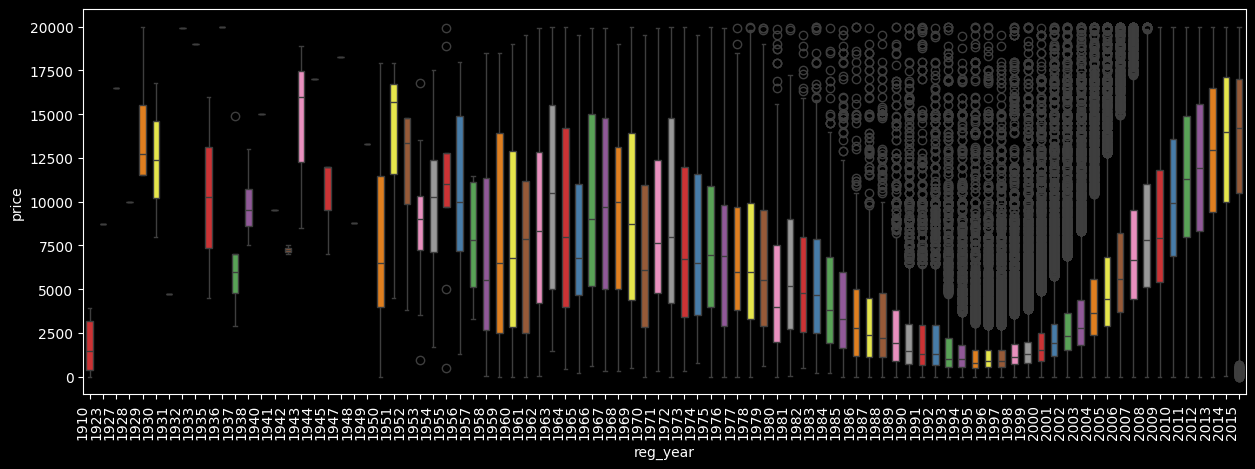

In [37]:
# посмотрим на зависимость цены от года регистрации авто
plt.figure(figsize=(15,5))
sns.boxplot(x='reg_year', y='price', data=df, palette="Set1", width=0.5)
plt.xticks(rotation=90, ha='right')
plt.show()

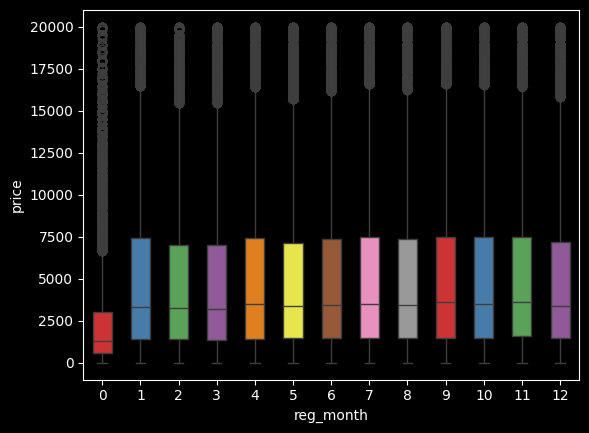

In [38]:
# посмотрим на зависимость цены от месяца регистрации авто
sns.boxplot(x='reg_month', y='price', data=df, palette="Set1", width=0.5)
plt.show()

In [39]:
# сконвертируем столбцы с датой в формат datetime64
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_last_seen'] = pd.to_datetime(df['date_last_seen'], format='%Y-%m-%d %H:%M:%S')

In [40]:
# посмотрим какие уникальные значения года есть в столбцах
print(df['date_created'].dt.year.unique())
print(df['date_crawled'].dt.year.unique())
print(df['date_last_seen'].dt.year.unique())

[2016 2015]
[2016]
[2016]


In [41]:
# посмотрим на соотношение количества записей по разным годам в столбце даты создания
df['date_created'].dt.year.value_counts()

date_created
2016    290069
2015        24
Name: count, dtype: int64

In [42]:
# создадим отдельные столбцы с месяцами по каждому из столбцов
df['month_created'] = df['date_created'].dt.month
df['month_crawled'] = df['date_crawled'].dt.month
df['month_last_seen'] = df['date_last_seen'].dt.month

# создадим мини датасет со сводной информацией по средней цене за месяца
month = pd.DataFrame({'created': df.groupby('month_created')['price'].mean(),
                     'crawled': df.groupby('month_crawled')['price'].mean(),
                     'last seen': df.groupby('month_last_seen')['price'].mean()})

# посмотрим на эти данные
month

,created,crawled,last seen
1,8341.88,NaN,NaN
2,6367.48,NaN,NaN
3,4864.26,4866.11,4095.27
4,5086.82,5092.07,5490.21
8,9725.00,NaN,NaN
9,3566.67,NaN,NaN
11,7753.89,NaN,NaN
12,7249.89,NaN,NaN


In [43]:
# посмотрим на количество записей по месяцам в столбце даты создания
df.groupby('month_created')['price'].count()

month_created
1         57
2        351
3     242669
4      46993
8          2
9          3
11         9
12         9
Name: price, dtype: int64

In [44]:
# повторим для других столбцов
df.groupby('month_crawled')['price'].count()

month_crawled
3    242735
4     47358
Name: price, dtype: int64

In [45]:
df.groupby('month_last_seen')['price'].count()

month_last_seen
3    122118
4    167975
Name: price, dtype: int64

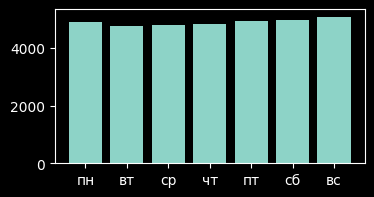

In [46]:
# создадим столбцы  по неделям
df['weekday_created'] = df['date_created'].dt.weekday
df['weekday_crawled'] = df['date_crawled'].dt.weekday
df['weekday_last_seen'] = df['date_last_seen'].dt.weekday

# создадим сводную таблицу со средними ценами за неделю
week = pd.DataFrame({'created': df.groupby('weekday_created')['price'].mean(),
                     'crawled': df.groupby('weekday_crawled')['price'].mean(),
                     'last seen': df.groupby('weekday_last_seen')['price'].mean()})

# выведем эти данные в виде таблиц
bars = ('пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс')
y_pos = np.arange(len(bars))

plt.figure(figsize=(4,2))
plt.bar(y_pos, week['created'])
plt.xticks(y_pos, bars)
plt.show()

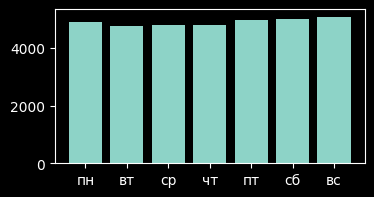

In [47]:
plt.figure(figsize=(4,2))
plt.bar(y_pos, week['crawled'])
plt.xticks(y_pos, bars)
plt.show()

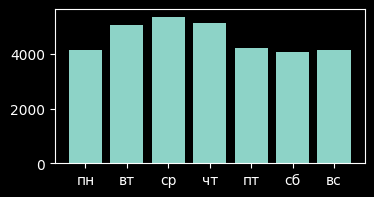

In [48]:
plt.figure(figsize=(4,2))
plt.bar(y_pos, week['last seen'])
plt.xticks(y_pos, bars)
plt.show()

Год регистрации авто

Цены на авто 20 и менее лет, падают чем старше автомобиль, после 20 лет цены наоборот начинают расти, начинается сегмент ретро автомобилей. Тут можно создать дополнительный класс для сегментации на ретро/новые.

Месяц регистрации авто

во всех 12 месяцах нет никакого значимого влияния на цену, к тому же есть непонятный нулевой месяц, который как раз на цену влияет. Возможно люди продающие старый и дешевый автомобиль не удосуживаются вписать месяц корректно. Как бы то ни было, этот столбец нам только мешает, избавимся от него.


столбцы с датами создания/регистрации/выгрузки

Год везде один во всех трёх столбцах за исключением нескольких записей не 2016го года а одном столбце, которыми можно принебречь.

Почти все записи приходятся на 3 и 4 месяцы во всех трёх столбцах с датами, это странно, причина этого не ясна, но использовать такие данные сомнительная идея.

дни недели из двух столбцов почти не вилияют, есть незначительное вличние на цену в столбце, который отвечает за последнее появление пользователя на сайте. это странно, цена автомобиль вряд ли зависит от того, когда человек последний раз был на сайте.

Выглядит так что эти столбцы можно просто удалить и не нагружать ими модель, она без них быстрее будет обучатся и эти данные не внесут погрешностей, так что и качество будет лучше без них.

In [49]:
df = df.drop(['date_created','date_crawled','date_last_seen',
              'weekday_created','weekday_crawled','weekday_last_seen',
              'month_created', 'month_crawled', 'month_last_seen',
              'reg_month'
              ], axis=1)

In [50]:
def retro_classifier(year):
    if year < 1996:
        return 1
    else:
        return 0

df['retro'] = df['reg_year'].apply(retro_classifier)

## Обучение моделей

Разобьём датасет на выборки

In [51]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train_n_valid, X_test, y_train_n_valid, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1337)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_n_valid, y_train_n_valid, test_size=0.25, random_state=1337)

print('Размер тренировочной выборки:')
print(f'признаки {X_train.shape};')
print(f'целевой признак {y_train.shape}')
print(f'это {round((y_train.count() / y.count()) * 100)}% от датасета')
print()
print('Размер валидационной выборки:')
print(f'признаки {X_valid.shape};')
print(f'целевой признак {y_valid.shape}')
print(f'это {round((y_valid.count() / y.count()) * 100)}% от датасета')
print()
print('Размер тестовой выборки:')
print(f'признаки {X_test.shape};')
print(f'целевой признак {y_test.shape}')
print(f'это {round((y_test.count() / y.count()) * 100)}% от датасета')

Размер тренировочной выборки:
признаки (174055, 11);
целевой признак (174055,)
это 60% от датасета

Размер валидационной выборки:
признаки (58019, 11);
целевой признак (58019,)
это 20% от датасета

Размер тестовой выборки:
признаки (58019, 11);
целевой признак (58019,)
это 20% от датасета


Закодируем параметры методом `BinaryEncoder`

In [52]:
# обозначаем названия столбцов для кодировки списком
x_to_enc = ['vehicle_type','fuel_type','brand','model','gearbox','repaired']

# выбираем кодировщик
bn = BinaryEncoder()

# сбрасываем индексы в выборка для корректного объединения кодированных данных с остальной таблицей в дальнейшем
X_train.reset_index(inplace=True)
X_train.drop(['index'], axis=1, inplace=True)
X_valid.reset_index(inplace=True)
X_valid.drop(['index'], axis=1, inplace=True)
X_test.reset_index(inplace=True)
X_test.drop(['index'], axis=1, inplace=True)

# кодируем выбранные столбцы по списку названий в выборках обучая кодировщик на них же
coded_X_train = bn.fit_transform(X_train[x_to_enc].values)
coded_X_valid = bn.transform(X_valid[x_to_enc].values)
coded_X_test = bn.transform(X_test[x_to_enc].values)

# удаляем из выборок оригинальные, не закодированные столбцы
X_train = X_train.drop(x_to_enc, axis=1)
X_valid = X_valid.drop(x_to_enc, axis=1)
X_test = X_test.drop(x_to_enc, axis=1)

# добавляем в выборки закодированные столбцы
X_train = pd.concat([X_train, coded_X_train], axis=1)
X_valid = pd.concat([X_valid, coded_X_valid], axis=1)
X_test = pd.concat([X_test, coded_X_test], axis=1)

Создадим переменную для кросс валидации

In [53]:
cv = KFold(n_splits=5, random_state=1337, shuffle=True)

### RandomForestRegressor Model

найдём хорошие параметры с помощью `RandomizedSearchCV`. Для этого мы возьмём валидационную выборку, так как она меньше и процесс пройдёт быстрее.

In [54]:
rf_model = RandomForestRegressor()

rf_params = {'random_state': [1337],
             'n_estimators': range(100, 1001, 100),
             'max_depth': [1,4,8,12,16,20],
             'min_samples_split' : [2,6,10,16],
             'min_samples_leaf' : [1,2,4,8,16]
             }

rf_rndsch = RandomizedSearchCV(rf_model,
                               param_distributions = rf_params,
                               n_iter = 20,
                               scoring='neg_root_mean_squared_error',
                               error_score='raise',
                               cv = cv,
                               random_state = 1337,
                               n_jobs = -1
                               )

rf_rndsch.fit(X_valid, y_valid)

rf_rmse = abs(rf_rndsch.best_score_)

print('значение RMSE модели случайного леса:')
print(rf_rmse)
print('при следующих параметрах:')
print(rf_rndsch.best_params_)

значение RMSE модели случайного леса:
1732.9619596967764
при следующих параметрах:
{'random_state': 1337, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 16}


Параметры найденные с помощью RandomizedSearchCV:

            значение RMSE модели случайного леса:
            1732.9619596967764
            при следующих параметрах:
            {'random_state': 1337, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 16}

Перебор параметров осуществлён среди данного пространства вариантов:

            {'random_state': [1337],
             'n_estimators': range(100, 1001, 100),
             'max_depth': [1,4,8,12,16,20],
             'min_samples_split' : [2,6,10,16],
             'min_samples_leaf' : [1,2,4,8,16]
             }

Затраченное на поиск время 20 минут

Используем найденные параметры для обучения модели уже на тренировочной выборке и проверим на валидационной

In [55]:
rf_model = RandomForestRegressor(random_state=1337,
                              n_estimators=200,
                              max_depth=16,
                              min_samples_split=2,
                              min_samples_leaf=2
                              )

In [56]:
%%time
rf_model.fit(X_train, y_train)

CPU times: total: 2min 3s
Wall time: 2min 20s


RandomForestRegressor(max_depth=16, min_samples_leaf=2, n_estimators=200,
                      random_state=1337)

In [57]:
%%time
predict_valid = rf_model.predict(X_valid)

CPU times: total: 1.94 s
Wall time: 2.11 s


In [58]:
rf_rmse = mean_squared_error(predict_valid, y_valid)**0.5
print('RMSE модели случайного леса:', round(rf_rmse, 2))

RMSE модели случайного леса: 1595.56


### LightGBM Model

Для начала впишем параметры для модели градиентного бустинга руками, чтобы понимать от чего мы отталкиваемся

In [59]:
%%time

gb1_model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective='regression',
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=1337,
    silent=True
    )

gb1_rmse = cross_val_score(gb1_model, X_valid, y_valid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print(f'RMSE модели градиентного бустинга LightGBM {round(abs(np.mean(gb1_rmse)), 2)}')

RMSE модели градиентного бустинга LightGBM 1704.72
CPU times: total: 0 ns
Wall time: 1.46 s


Найдём параметры, которые повысят наше качество с помощью `RandomizedSearchCV`

In [60]:
gbrs_model = LGBMRegressor(
                    objective='regression',
                    min_split_gain=0.0,
                    min_child_samples=20,
                    subsample=1.0,
                    subsample_freq=0,
                    colsample_bytree=1.0,
                    reg_alpha=0.0,
                    reg_lambda=0.0,
                    seed=1337
                )

gb_parameters = {'num_leaves': [21, 31, 41, 60],
                'max_depth': [-1, 0, 1, 16, 32],
                'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
                'n_estimators': [100, 200, 400]
                }
                
gb_rndsch = RandomizedSearchCV(gbrs_model, 
                               param_distributions = gb_parameters,
                               n_iter = 300, 
                               scoring='neg_root_mean_squared_error', 
                               error_score='raise', 
                               cv = cv,
                               random_state = 1337,
                               n_jobs = -1
                               )

gb_rndsch.fit(X_valid, y_valid)

gb_rndsch_rmse = abs(gb_rndsch.best_score_)

print('значение RMSE LightGBM модели градиентного бустинга:')
print(gb_rndsch_rmse)
print('при следующих параметрах:')
print(gb_rndsch.best_params_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 58019, number of used features: 30
[LightGBM] [Info] Start training from score 4917.237681
значение RMSE LightGBM модели градиентного бустинга:
1626.133687051163
при следующих параметрах:
{'num_leaves': 60, 'n_estimators': 400, 'max_depth': 16, 'learning_rate': 0.1}


Параметры найденные с помощью RandomizedSearchCV:

            значение RMSE LightGBM модели градиентного бустинга:
            1626.133687051163
            при следующих параметрах:
            {'num_leaves': 60, 'n_estimators': 400, 'max_depth': 16, 'learning_rate': 0.1}
            
Перебор параметров осуществлён среди данного пространства вариантов:

            {'num_leaves': [21, 31, 41, 60],
             'max_depth': [-1, 0, 1, 16, 32],
             'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
             'n_estimators': [100, 200, 400]
             }

Затраченное на поиск время 3 минуты

Проверим найденные параметры на валидационной выборке и сравним результаты

In [61]:
%%time

gb2_model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=60,
    max_depth=16,
    learning_rate=0.1,
    n_estimators=400,
    objective='regression',
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=1337,
    silent=True
    )

gb2_rmse = cross_val_score(gb2_model, X_valid, y_valid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print(f'RMSE модели градиентного бустинга LightGBM {round(abs(np.mean(gb2_rmse)), 2)}')

RMSE модели градиентного бустинга LightGBM 1626.13
CPU times: total: 141 ms
Wall time: 3.51 s


Качество улучшилось с 1704.72 до 1626.13, при этом время затраченное на обучение модели на кросс валидации и расчет метрики выросло с 12.8 s до 59.6 s.
Как видим прирост в качестве совершенно не пропорционален затраченному времени, скорость обучения уменьшилась в разы, а так как скорость обучения нам тоже важна, то такое увелечение качества не стоит такого замедления процесса. В задании нам необходимо было добится качества RMSE не более 2500, а этих целей мы достигаем и с изначально взятыми параметрами, но с гораздо лучим временем обучения.


Обучим модель на тренировочной выборке

In [62]:
gb_model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective='regression',
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=1337,
    silent=True
    )

In [63]:
%%time
gb_model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 174055, number of used features: 31
[LightGBM] [Info] Start training from score 4893.555761
CPU times: total: 1.22 s
Wall time: 666 ms


LGBMRegressor(objective='regression', random_state=1337, silent=True)

In [64]:
%%time
gb_predict_valid = gb_model.predict(X_valid)

[LightGBM] [Warning] Unknown parameter: silent
CPU times: total: 375 ms
Wall time: 92.3 ms


In [65]:
gb_rmse = mean_squared_error(gb_predict_valid, y_valid)**0.5
print('RMSE модели градиентного бустинга:', round(gb_rmse, 2))

RMSE модели градиентного бустинга: 1673.48


## Анализ моделей

In [66]:
analys_df = pd.DataFrame({'Model': ['RandomForestRegressor Model', 'LightGBM Model'],
                          'RMSE': [rf_rmse, gb_rmse],
                          'CPU time: обучение': ['2min 45s', '5.38 s'],
                          'CPU time: предсказание': ['3.1 s', '460 ms']
                          })
analys_df

,Model,RMSE,CPU time: обучение,CPU time: предсказание
0,RandomForestRegressor Model,1595.56,2min 45s,3.1 s
1,LightGBM Model,1673.48,5.38 s,460 ms


В сравнении с моделью случайного леса, модель градиентного бустинга показывает огромный прирост в скорости обучения, при этом демонстрируя хорошее качество. В отличии от RandomForest, градиентный бустинг обучается не за минуты, а за секунды. Скорость предсказания тоже возрастает в два раза и исчисляется в долях секунды.

Подбирая параметры можно добится возможно и качества лучше чем у модели случайного леса, при этом скорость всё равно будет лучше, но т.к. стоит задача найти баланс между качеством и скоростью, принято решение оставить качество таким, чуть чуть хуже чем у случайного леса, в угоду скорости работы, которая на таких параметрах возрастает значительно


Проверим модель на тестовых данных

In [67]:
%%time
gb_predict_test = gb_model.predict(X_test)

[LightGBM] [Warning] Unknown parameter: silent
CPU times: total: 109 ms
Wall time: 69.3 ms


In [68]:
final_rmse = mean_squared_error(gb_predict_test, y_test)**0.5
print('RMSE модели:', round(final_rmse, 2))

RMSE модели: 1669.03


Вывод

В ходе работы были изучены и подготовлденны данные для обучения моделей. Проведён сравнительный анализ моделей случайного леса и градиентного бустинга.
Модель градиентного бустинга показала себя лучше во всех отношениях и в качестве и в скорости предсказания и особено в скорости обучения.

Итоговое RMSE модели на тестовой выборке равно 1669.03
Скорость обучения составила 5.38 s
Скорость предсказания 479 ms